# Lecture 2b: Introduction to Qiskit
**By Adam Fattal**

Welcome to the first practical lecture! In this lecture, we will be introducing qiskit, a package developed by IBM Quantum that allows one to simulate and run quantum circuits and much more! This lecture covers only the surface of Qiskit's functionality. For more, check out Qiskit's [documentation](https://qiskit.org/documentation/) here. 

## Importing Qiskit


In [11]:
from qiskit import *
import numpy as np

## Part 1: Building Circuits

Let's Try To Build these Quantum Circuits:

<img src='assets/1.png'>

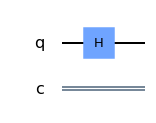

In [15]:
circ1 = QuantumCircuit(1,1)

circ1.h(0)

circ1.draw('mpl')

<img src='assets/2.png'>

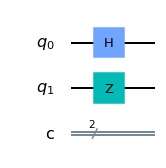

In [17]:
circ2 = QuantumCircuit(2,2)

circ2.h(0)
circ2.z(1)

circ2.draw('mpl')

<img src='assets/3.png'>

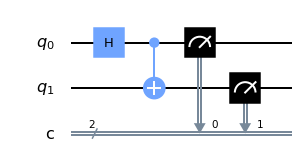

In [32]:
circ3 = QuantumCircuit(2,2)

circ3.h(0)
circ3.cx(0,1)
circ3.measure([0,1],[0,1])
circ3.draw('mpl')

## Part 2: Using Quantum Circuits

### Statevectors

In [28]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ2,backend = simulator).result()
psi = result.get_statevector()
psi

array([ 0.70710678+0.j,  0.70710678+0.j, -0.        +0.j, -0.        +0.j])

In [29]:
np.linalg.norm(psi)

1.0

### Getting the Unitary

In [27]:
simulator = Aer.get_backend('unitary_simulator')
result = execute(circ3,backend = simulator).result()
U = result.get_unitary()

U@np.array([1,0,0,0])

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

### Getting the Bloch Spheres

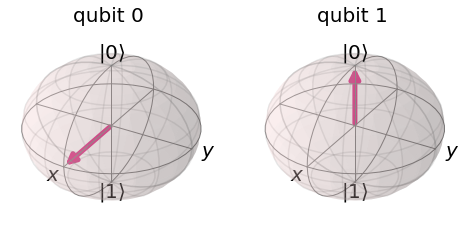

In [30]:
from qiskit.tools.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)

### Simulating Results

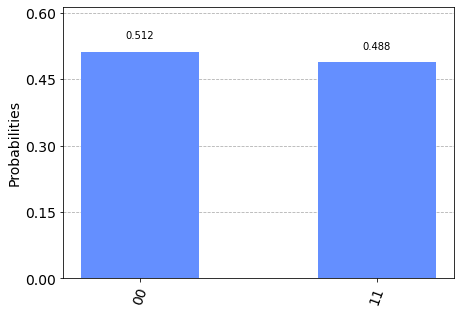

In [34]:
from qiskit.tools.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')
result = execute(circ3,backend, shots = 420).result()
output = result.get_counts()
plot_histogram(output)

### Full Example

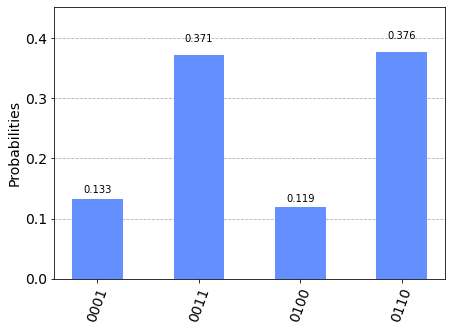

In [39]:
qc = QuantumCircuit(4,4)

qc.h(0)
qc.rx(np.pi/3, 1)
qc.x(1)
qc.y(2)
qc.z(3)
qc.cnot(0,2)
qc.measure([i for i in range(3)], [i for i in range(3)])

qc.draw('mpl')

backend = Aer.get_backend('qasm_simulator')
result = execute(qc,backend, shots = 420).result()
output = result.get_counts()
plot_histogram(output)

## Part 3: Running circuits on a real quantum computer


In [7]:
#Defining a quantum circuit with 2 qubits and 2 classical bits
phiPlus = QuantumCircuit(2,2)

#Preparing a |Φ+> state
phiPlus.h(0)
phiPlus.cnot(0,1)
phiPlus.measure([0,1],[0,1])


#This is what you type to run on real IBMQ hardware

IBMQ.load_account() #This is how you load your account
provider = IBMQ.get_provider('ibm-q') #This is how you get the ibm-q provider
qcomp = provider.get_backend('ibmq_16_melbourne') #This is how you select the device you want to use
job = execute(phiPlus, backend=qcomp, shots=1024) #This is how you tell the device which circuit to run
from qiskit.tools.monitor import job_monitor
job_monitor(job) #Monitor the job
result = job.result() #Get Results

result

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Job Status: job has successfully run


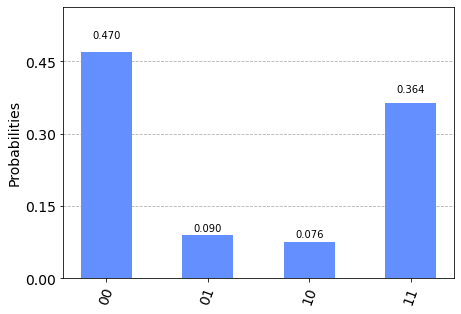

In [10]:
plot_histogram(result.get_counts(phiPlus))

## Part 4: Grover's Algorithm Demonstration

In [40]:
PI = np.pi

def groverCircuit(target):

    target_list = [int(x) for x in str(target)] #Converts the target into a list (e.g '1001' => [1,0,0,1])
    n = len(target_list) #Length of target list (i.e nbr of qubits)
    counter = [i for i in range(n)] #List containing integers from 0 to num_qubits - 1

    #Defining a CnP gate. Note that CnP(PI) = CNZ
    def mcp(self, lam, control_qubits, target_qubit):
        from qiskit.circuit.library import MCPhaseGate
        num_ctrl_qubits = len(control_qubits)
        return self.append(MCPhaseGate(lam, num_ctrl_qubits), control_qubits[:] + [target_qubit],
                    [])

    #Sub-circuit 1: Hadamard on all qubits
    def hadamards(target):
        hadCirc = QuantumCircuit(n,n)
        hadCirc.h(counter)
        hadCirc.barrier()
        return hadCirc

    #Sub-circuit 2: Oracle 
    def oracle(target):
        filtered = [counter[i] for i in range(n) if target_list[i]==0] #Filtering the counter list to only the indices where target==0
        oracleCirc = QuantumCircuit(n,n)
        if filtered != []:
            oracleCirc.x(filtered) #In other words, if target only has 1s, do nothing 
        mcp(oracleCirc, np.pi, [i for i in range(n-1)],n-1)
        if filtered != []:
            oracleCirc.x(filtered) #Applying X gates to the qubits which represent 0
        oracleCirc.barrier()
        return oracleCirc

    #Sub-circuit 3: Amplifier
    def amplification(target):
        ampCirc = QuantumCircuit(n,n)
        ampCirc.h(counter)
        ampCirc.x(counter)
        mcp(ampCirc, np.pi, [i for i in range(n-1)],n-1)
        ampCirc.x(counter)
        ampCirc.h(counter)
        ampCirc.barrier()
        return ampCirc

    k = round(PI*n/4 - 0.5) #Ideal number of iterations. k = π/4 * √N - 1/2. 

    circuit = hadamards(target) 

    for i in range(k): #Iterating the oracle and amplification 
        circuit+=oracle(target)
        circuit+= amplification(target)

    circuit.measure(counter, counter)
    return circuit

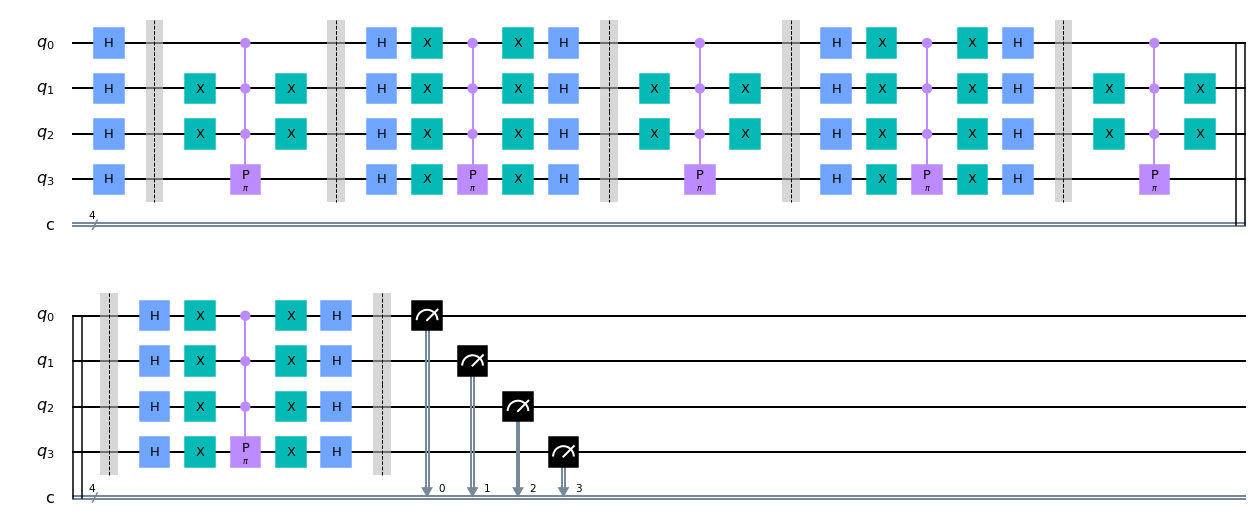

In [41]:
from qiskit.tools.visualization import plot_histogram
circuit = groverCircuit('1001')

backend = Aer.get_backend('qasm_simulator')
result = execute(circuit,backend, shots = 420).result()
output = result.get_counts()
circuit.draw('mpl')

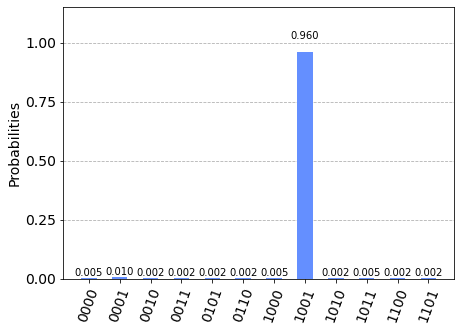

In [42]:
plot_histogram(output)

## Further Reading:


[1] <a href='https://www.youtube.com/watch?v=a1NZC5rqQD8&list=PLOFEBzvs-Vvp2xg9-POLJhQwtVktlYGbY'>Qiskit Tutorial by Qiskit</a>

[2] <a href='https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html'>Qiskit Summary of Operations </a>

[3] <a href='https://qiskit.org/textbook/preface.html'>Qiskit Textbook</a>

[4] <a href='https://www.youtube.com/watch?v=yprDIC-9D0k'>Getting Started with Qiskit Demo </a>